## 第７章: ロジスティックネットワークの最適設計を行う１０本ノック

> ## 準備

In [1]:
# フォルダーに移動
% cd /content/drive/My Drive/Colab Notebooks/deeplab/data_analysis_100/

/content/drive/My Drive/Colab Notebooks/deeplab/data_analysis_100


In [2]:
% ls サンプルコード_20200325/7章

'7章 ロジスティクスネットワークの最適設計を行う10本ノック_answer.ipynb'
'7章 ロジスティクスネットワークの最適設計を行う10本ノック.ipynb'
 demand.csv
 product_plan.csv
 product_plan_material.csv
 product_plan_profit.csv
 product_plan_stock.csv
 supply.csv
 trans_cost.csv
 trans_route_pos.csv


In [3]:
# 日本語フォント用
!pip install japanize-matplotlib

In [4]:
# Load libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/japanize_matplotlib/japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [5]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Config
PATH = './サンプルコード_20200325/7章/'

In [7]:
# データのロード
from os import listdir
for file in listdir(PATH):
  if file.endswith('.csv'):
    file_name = 'df_{}'.format(file.replace('.csv', ''))
    globals()[file_name] = pd.read_csv(PATH+file)
    print(file_name)

df_product_plan_stock
df_trans_cost
df_demand
df_product_plan_material
df_supply
df_trans_route_pos
df_product_plan
df_product_plan_profit


> ## ノック61:輸送晨適化問題を解いてみよう

pulp と ortoolpy は初めて使うので、基本教科書通りに進めます。

### pulp
- https://docs.pyq.jp/python/math_opt/pulp.html
- https://qiita.com/mzmttks/items/82ea3a51e4dbea8fbc17

In [8]:
! pip install pulp
! pip install ortoolpy

In [9]:
# libraryの読み込み
from pulp import LpVariable, lpSum, value
from ortoolpy import model_min, addvars, addvals
from itertools import product

In [10]:
df_trans_cost.set_index('工場', drop=True, inplace=True)
df_trans_cost

,F1,F2,F3,F4
工場,,,,
W1,10,10,11,27
W2,18,21,12,14
W3,15,12,14,12


In [11]:
df_demand

,F1,F2,F3,F4
0,28,29,31,25


In [12]:
df_supply

,W1,W2,W3
0,35,41,42


In [13]:
# pupl は初めて使うライブラリなので、自分用にコメント色々書いてます。見辛くてすみません。

np.random.seed(0)
n_wh = len(df_trans_cost.index)
n_fc= len(df_trans_cost.columns)
pr = list(product(range(n_wh), range(n_fc)))

# 最小化したい目的関数のインスタンスを定義
m1 = model_min()

# 変数の定義 (LpVariable(変数名, バウンド))
v1 = {(i, j): LpVariable('v%d_%d'%(i,j), lowBound=0) for i, j in pr}

# 目的変数の定義 (各輸送ルートのコストと最適化したい変数の積の和)
m1 += lpSum(df_trans_cost.iloc[i][j]*v1[i,j] for i, j in pr)

# 制約条件の定義
# 供給側 (各倉庫の供給量上限を下回っているか)
for i in range(n_wh):
  m1 += lpSum(v1[i, j] for j in range(n_fc)) <= df_supply.iloc[0][i]
# 需要側 (各向上の最低需要量を上回っているか)
for j in range(n_fc):
  m1 += lpSum(v1[i, j] for i in range(n_wh)) >= df_demand.iloc[0][j]

# 最適化
m1.solve()

# 総輸送コスト計算
df_trans_cost_sol = df_trans_cost.copy()
total_cost = 0

for k,x in v1.items():
    i,j = k[0],k[1]
    df_trans_cost_sol.iloc[i][j] = value(x)
    total_cost += df_trans_cost.iloc[i][j]*value(x)

    
print(df_trans_cost_sol)
print("総輸送コスト:"+str(total_cost))


    F1  F2  F3  F4
工場                
W1  28   7   0   0
W2   0   0  31   5
W3   0  22   0  20
総輸送コスト:1296.0


コストはChapter6で手動で計算した1493より 203低く抑えられている。

> ## ノック62:最適輸送ルートをネットワークで確認しよう

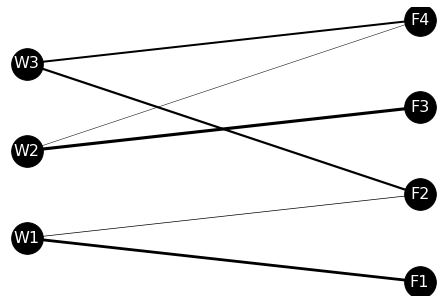

In [14]:
import networkx as nx


G = nx.Graph()
pos = {}

list_F = df_trans_cost.columns
list_W = df_trans_cost.index
list_FW = df_trans_route_pos.columns

# ノードと座標の追加
for col in list_FW:
  G.add_node(col)
  pos[col] = (df_trans_route_pos[col][0], df_trans_route_pos[col][1])

# エッジと重みの追加
edge_weights = []

for w in list_W:
  for f in list_F:
    G.add_edge(w, f)
    edge_weights.append(df_trans_cost_sol[f][w]*0.1)

# 描画
nx.draw(G, pos, with_labels=True, font_size=16, node_size = 1000, node_color='k', font_color='w', width=edge_weights)

# 表示
plt.show()

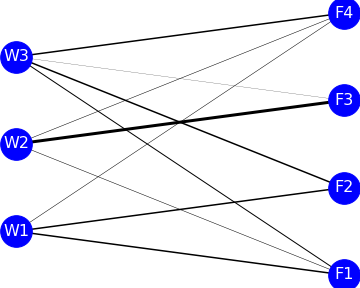

In [15]:
# Chapter 6 で手動で計算したルート
from IPython.display import Image
Image( './サンプルコード_20200325/6章/Ch6_manual_route.png')

- 基本的にW1がF1に、W2からF3に、W3からF2への輸送が多いのは変わらないが、いくつかのルートがなくなった。
- 輸送元はある程度まとめた方が良さそう。

> ## ノック63:最適輸送ルートが制約条件内に収まっているかどうかを確認しよう

In [16]:
# 工場からの需要量
def check_demand_condition(df_trans_route, df_demand):
  demand_flag = {}
  for i in range(len(df_demand.columns)):
    temp_sum = sum(df_trans_route[df_demand.columns[i]])
    if temp_sum>=df_demand.iloc[0][i]:
      demand_flag[df_demand.columns[i]] = 1
    else:
      demand_flag[df_demand.columns[i]] = 0
  print('需要条件計算結果： ', demand_flag)

# 倉庫からの供給量
def check_supply_condition(df_trans_route, df_supply):
  supply_flag = {}
  for i in range(len(df_supply.columns)):
    temp_sum = sum(df_trans_route.loc[df_supply.columns[i]])
    if temp_sum<=df_supply.iloc[0][i]:
      supply_flag[df_supply.columns[i]] = 1
    else:
      supply_flag[df_supply.columns[i]] = 0
  print('供給条件計算結果： ', supply_flag)

In [17]:
check_demand_condition(df_trans_cost_sol, df_demand)
check_supply_condition(df_trans_cost_sol, df_supply)

需要条件計算結果：  {'F1': 1, 'F2': 1, 'F3': 1, 'F4': 1}
供給条件計算結果：  {'W1': 1, 'W2': 1, 'W3': 1}


需要側も供給側も条件が満たされているのを確認

> ## ノック64::生産計画に関するデータを読み込んでみよう

In [18]:
# 製品ごとの原料
df_product_plan_material.set_index('製品', drop = True, inplace=True)
df_product_plan_material

,原料1,原料2,原料3
製品,,,
製品1,1,4,3
製品2,2,4,1


In [19]:
# 原料の在庫状況
df_product_plan_stock.set_index('項目', drop=True, inplace=True)
df_product_plan_stock

,原料1,原料2,原料3
項目,,,
在庫,40,80,50


In [20]:
# 製品ごとの利益
df_product_plan_profit.set_index('製品', drop=True, inplace=True)
df_product_plan_profit

,利益
製品,
製品1,5.0
製品2,4.0


In [21]:
# 製品ごとの生産量
df_product_plan.set_index('製品', drop=True,  inplace=True)
df_product_plan

,生産量
製品,
製品1,16
製品2,0


> ## ノック65:利益を計算する関数を作ってみよう

In [22]:
# 総利益を計算する関数
def calc_profit(df_profit, df_plan):
  return sum(df_profit.iloc[:, 0]*df_plan.iloc[:,0])

In [23]:
print('総利益: ' + str(calc_profit(df_product_plan_profit, df_product_plan)))

総利益: 80.0


> ## ノック66:生産最適化問題を解いてみよう

pulp を使って利益が最大となる生産量を求める.

In [24]:
from pulp import LpVariable, lpSum, value
from ortoolpy import model_max, addvars, addvals

# 最大化する目的関数
m = model_max()

# 求めたい変数の定義 (生産量)
v1 = {(i): LpVariable('v%d'%(i), lowBound=0) for i in range(len(df_product_plan_profit))}

# 最大化する値の定義 (生産量*個別利益)
m += lpSum(df_product_plan_profit.iloc[i]*v1[i] for i in range(len(df_product_plan_profit)))

# 制約条件の定義
# 生産量に対して必要な材料が在庫量を下回っているか
for i in range(len(df_product_plan_material.columns)):
  m+= lpSum(df_product_plan_material.iloc[j, i]*v1[j] for j in range(len(df_product_plan_profit)))<=df_product_plan_stock.iloc[:, i]

# 最適化
m.solve()

1

In [25]:
df_product_plan_sol = df_product_plan.copy()
for k, x in v1.items():
  df_product_plan_sol.iloc[k] = value(x)
print(df_product_plan_sol)
print('総利益: '+str(calc_profit(df_product_plan_profit, df_product_plan_sol)))

      生産量
製品       
製品1  15.0
製品2   5.0
総利益: 95.0


製品１だけを生産した場合に比べて15万円増収。

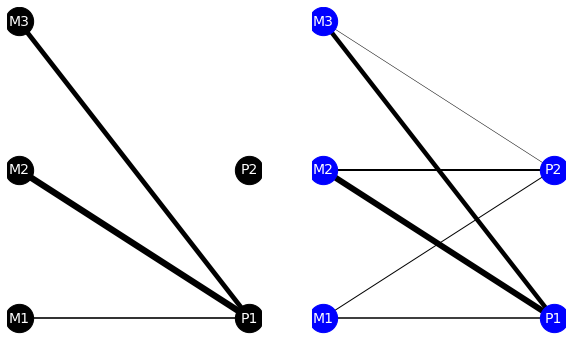

In [26]:
# 材料の分配を可視化してみる

G = nx.Graph()
pos = {}

list_M = list(df_product_plan_material.columns)
list_P = list(df_product_plan_material.index)

# ノードと座標の追加
# M: 原料  
# P:  製品
for i in range(len(list_M)):
  G.add_node('M%d'%(i+1))
  pos['M%d'%(i+1)] = (0, i)
for i in range(len(list_P)):
  G.add_node('P%d'%(i+1))
  pos['P%d'%(i+1)] = (1, i)

# エッジと重みの追加
edge_weights_opt = []
edge_weights_pre = []

for i in range(len(list_M)):
  for j in range(len(list_P)):
    m = list_M[i]
    p = list_P[j]
    G.add_edge('M%d'%(i+1), 'P%d'%(j+1))
    edge_weights_opt.append(df_product_plan_sol.loc[p][0]*df_product_plan_material.loc[p][m]*0.1)
    edge_weights_pre.append(df_product_plan.loc[p][0]*df_product_plan_material.loc[p][m]*0.1)

# 描画
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
nx.draw(G, pos, with_labels=True, font_size=14, node_size = 800, node_color='k', font_color='w', width=edge_weights_pre, ax=axes[0])
nx.draw(G, pos, with_labels=True, font_size=14, node_size = 800, node_color='b', font_color='w', width=edge_weights_opt, ax=axes[1])

# 表示
plt.show()

左:  最適化前 ,  右: 最適化後



> ## ノック67:最摘生産計画が制約条件内に収まっているかどうかを確認しよう

In [27]:
def check_stock_condition(df_product_plan_stock, df_product_plan_material, df_product_plan):
  flag = {f:0 for f in df_product_plan_stock.columns}
  for material in df_product_plan_stock.columns:
    temp_sum = 0
    for product in df_product_plan_material.index:
      temp_sum += df_product_plan_material.loc[product][material]*df_product_plan.loc[product][0]

    if(temp_sum <= float(df_product_plan_stock[material][0])):
      flag[material] = 1
    print(material + '    使用量： ' + str(temp_sum) + ', 在庫：' + str(float(df_product_plan_stock[material])))
  return flag


In [28]:
check_stock_condition(df_product_plan_stock, df_product_plan_material, df_product_plan_sol)

原料1    使用量： 25.0, 在庫：40.0
原料2    使用量： 80.0, 在庫：80.0
原料3    使用量： 50.0, 在庫：50.0


{'原料1': 1, '原料2': 1, '原料3': 1}

> ## ノック68:ロジスティクスネットワーク設計問題を解いてみよう


- 目的：輸送コストと生産コストの合計を最小化
- 制約：需要を販売数を下回らないようにする

ortoolpyライブラリの logistics_networksという機能を使っていきます。
#### ortoolpy公式Doc
https://pydoc.net/ortoolpy/0.2.10/ortoolpy.etc/
- はじめて ortoolpy 使いましたが、他にも色々最適化問題ソルバが揃ってて面白そう。


In [29]:

# 問題設定
products = list('AB')
shops = list('PQ')
factories = list('XY')
lane = (2,2)

"""
https://pydoc.net/ortoolpy/0.2.10/ortoolpy.etc/
line 816

logistics_network():
    tbde: 需要地 製品 需要
    tbdi: 需要地 工場 輸送費
    tbfa: 工場 製品 生産費 (下限) (上限)
    出力: 解の有無, 輸送表, 生産表
"""

# 輸送費表 
tbdi = pd.DataFrame(((j,k) for j in shops for k in factories), columns=['需要地','工場'])
tbdi['輸送費'] = [1,2,3,1]
print('輸送表')
print(tbdi)

# 需要表 
tbde = pd.DataFrame(((j,i) for j in shops for i in products), columns=['需要地','製品'])
tbde['需要'] = [10,10,20,20]
print('需要表')
print(tbde)

# 生産表 
tbfa = pd.DataFrame(((k,l,i,0,np.inf) for k,nl in zip (factories,lane) for l in range(nl) for i in products), 
                    columns=['工場','レーン','製品','下限','上限'])
tbfa['生産費'] = [1,np.nan,np.nan,1,3,np.nan,5,3]
tbfa.dropna(inplace=True)
tbfa.loc[4,'上限']=10
print('生産表')
print(tbfa)

from ortoolpy import logistics_network
_, tbdi2, _ = logistics_network(tbde,tbdi,tbfa)
print('生産票(最適化後)')
print(tbfa)
print('輸送表(最適化後)')
print(tbdi2)


輸送表
  需要地 工場  輸送費
0   P  X    1
1   P  Y    2
2   Q  X    3
3   Q  Y    1
需要表
  需要地 製品  需要
0   P  A  10
1   P  B  10
2   Q  A  20
3   Q  B  20
生産表
  工場  レーン 製品  下限    上限  生産費
0  X    0  A   0   inf  1.0
3  X    1  B   0   inf  1.0
4  Y    0  A   0  10.0  3.0
6  Y    1  A   0   inf  5.0
7  Y    1  B   0   inf  3.0
生産票(最適化後)
  工場  レーン 製品  下限    上限  生産費     VarY  ValY
0  X    0  A   0   inf  1.0  v000009  20.0
3  X    1  B   0   inf  1.0  v000010  10.0
4  Y    0  A   0  10.0  3.0  v000011  10.0
6  Y    1  A   0   inf  5.0  v000012   0.0
7  Y    1  B   0   inf  3.0  v000013  20.0
輸送表(最適化後)
  需要地 工場  輸送費 製品     VarX  ValX
0   P  X    1  A  v000001  10.0
1   P  X    1  B  v000002  10.0
2   Q  X    3  A  v000003  10.0
3   Q  X    3  B  v000004   0.0
4   P  Y    2  A  v000005   0.0
5   P  Y    2  B  v000006   0.0
6   Q  Y    1  A  v000007  10.0
7   Q  Y    1  B  v000008  20.0


> ## ノック69:最適ネットワークにおける輸送コストとその内訳を計算しよう


In [30]:
# 輸送コスト:  輸送費*輸送製品個数

trans_cost = 0
for i in range(len(tbdi2.index)):
    trans_cost += tbdi2["輸送費"].iloc[i]*tbdi2["ValX"].iloc[i]
print("総輸送コスト:"+str(trans_cost))
print('(単位：万円)')

総輸送コスト:80.0
(単位：万円)


In [31]:
tbdi2

,需要地,工場,輸送費,製品,VarX,ValX
0,P,X,1,A,v000001,10.0
1,P,X,1,B,v000002,10.0
2,Q,X,3,A,v000003,10.0
3,Q,X,3,B,v000004,0.0
4,P,Y,2,A,v000005,0.0
5,P,Y,2,B,v000006,0.0
6,Q,Y,1,A,v000007,10.0
7,Q,Y,1,B,v000008,20.0


> ## ノック70:最適ネットワークにおける生産コストとその内訳を計算しよう

In [32]:
# 総生産コスト：生産費*生産製品個数

product_cost = 0
for i in range(len(tbfa.index)):
    product_cost += tbfa["生産費"].iloc[i]*tbfa["ValY"].iloc[i]
print("総生産コスト:"+str(product_cost))
print('(単位：万円)')

総生産コスト:120.0
(単位：万円)


In [33]:
tbfa

,工場,レーン,製品,下限,上限,生産費,VarY,ValY
0,X,0,A,0,inf,1.0,v000009,20.0
3,X,1,B,0,inf,1.0,v000010,10.0
4,Y,0,A,0,10.0,3.0,v000011,10.0
6,Y,1,A,0,inf,5.0,v000012,0.0
7,Y,1,B,0,inf,3.0,v000013,20.0
